<a href="https://colab.research.google.com/github/SasikaA073/PR-group-assignment/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 CNN for image classification

In [ ]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# !wget https://archive.ics.uci.edu/static/public/908/realwaste.zip

In [ ]:
# !unzip realwaste.zip

In [ ]:
from torchvision import datasets, transforms
import torch
from torch.utils.data import DataLoader

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
import os
num_workers = os.cpu_count()
print(f"Number of CPU cores: {num_workers}")

Number of CPU cores: 2


In [ ]:
# use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Get the mean and variance of the dataset

# Minimal transform to load images as tensors
transform = transforms.Compose([
    transforms.ToTensor()  # Convert to tensor
])

dataset = datasets.ImageFolder(root="realwaste-main/RealWaste", transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=num_workers)

In [ ]:
import torch

mean = 0.0
std = 0.0
total_images = 0

for images, _ in loader:
    batch_samples = images.size(0)  # Batch size (number of images in this batch)
    images = images.view(batch_samples, images.size(1), -1)  # Flatten height and width
    mean += images.mean(2).sum(0)  # Sum the mean of each channel
    std += images.std(2).sum(0)    # Sum the std of each channel
    total_images += batch_samples

mean /= total_images
std /= total_images

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

Mean: tensor([0.5979, 0.6191, 0.6317])
Standard Deviation: tensor([0.1551, 0.1636, 0.1820])


In [ ]:

transform = transforms.Compose([
    transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
])

data_dir = '/content/realwaste-main/RealWaste'

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_size = int(0.6 * len(dataset))  # 80% train, 20% validation
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# new transformation

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
image_datasets = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(val_dataset)}")
print(f"Number of testing examples: {len(test_dataset)}")

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Number of training examples: 2851
Number of validation examples: 950
Number of testing examples: 951


In [ ]:
print(f"{mean=}")
print(f"{std=}")

mean=tensor([0.5979, 0.6191, 0.6317])
std=tensor([0.1551, 0.1636, 0.1820])


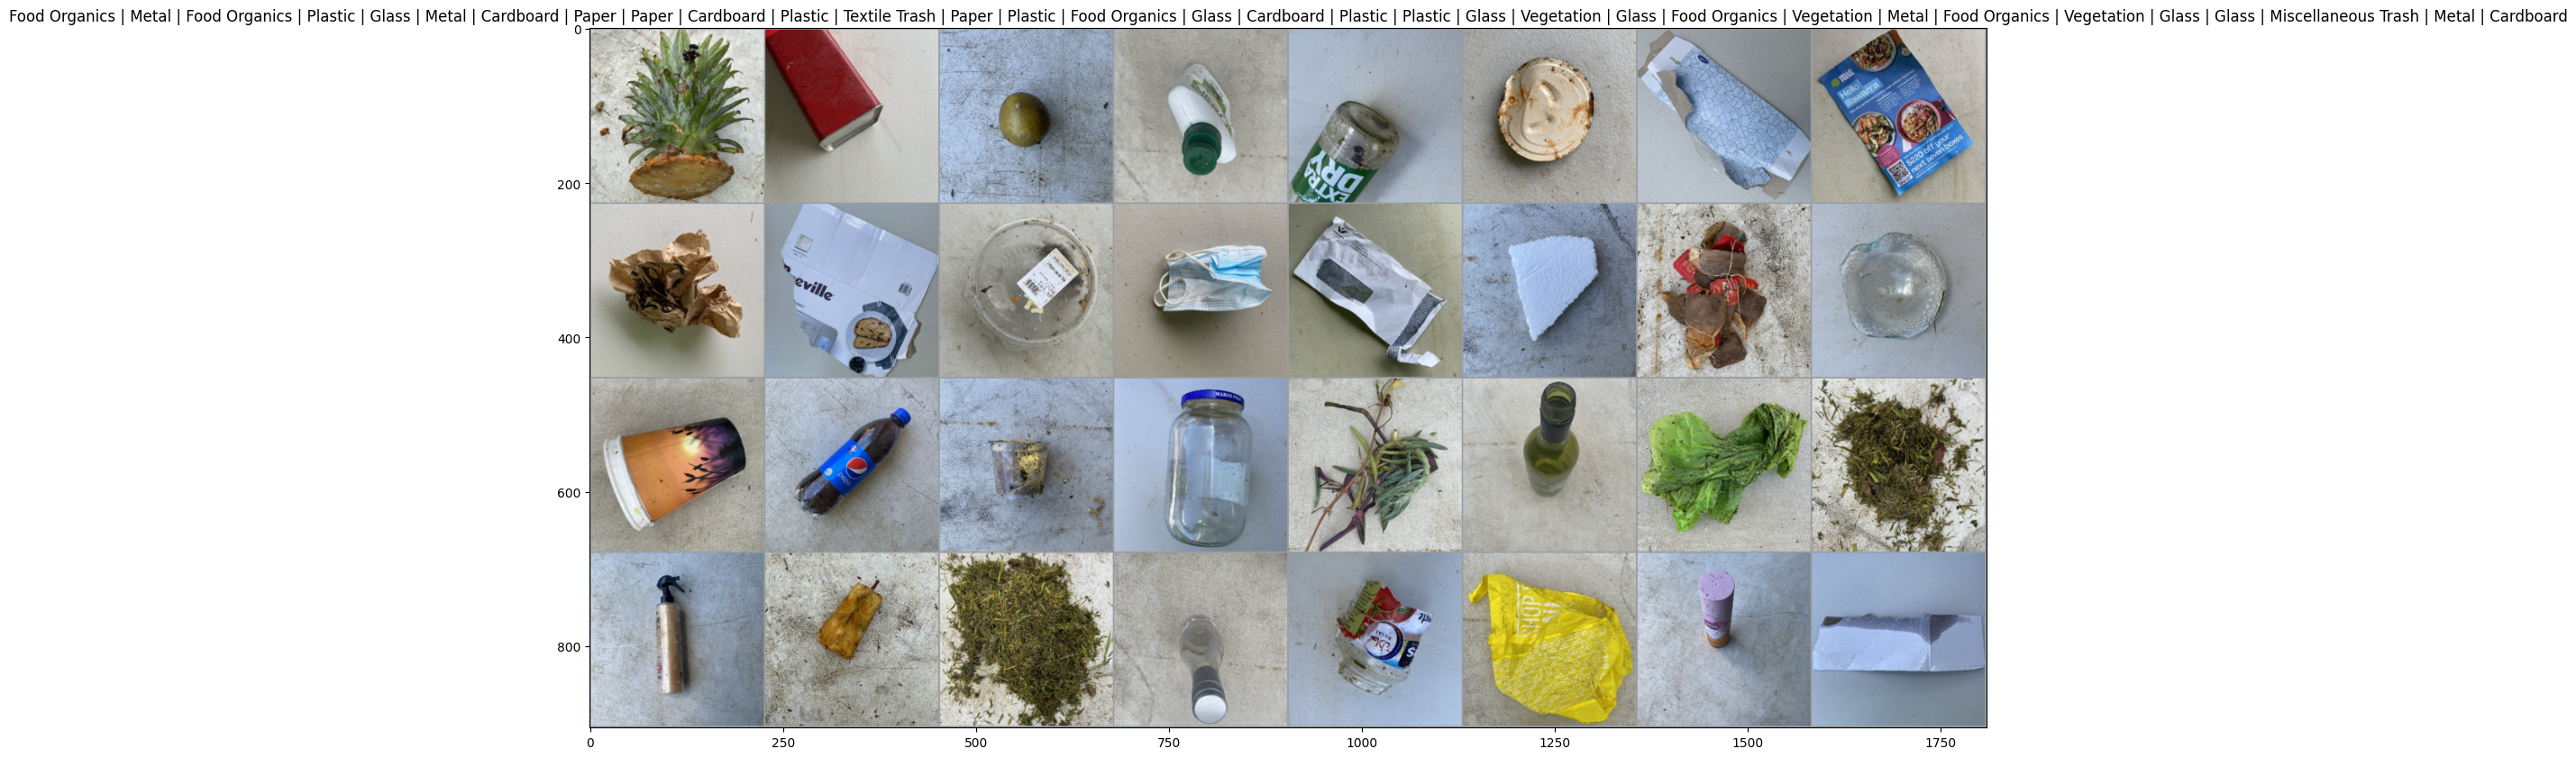

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision

def imshow(inp, title=None, figsize=(15, 15)):
    """Display image for Tensor with a larger figure size."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5979, 0.6191, 0.6317])
    std = np.array([0.1551, 0.1636, 0.1820])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    # Create a larger figure
    plt.figure(figsize=figsize)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from the batch
out = torchvision.utils.make_grid(inputs)

# Adjust the class names mapping as needed
class_names = image_datasets['train'].dataset.classes  # Use classes from the ImageFolder

# Display the image with a larger plot
imshow(out, title=" | ".join([class_names[x] for x in classes]), figsize=(20, 20))


In [ ]:
next(iter(train_loader))[0].shape

torch.Size([32, 3, 224, 224])

In [ ]:
dataset.classes

['Cardboard',
 'Food Organics',
 'Glass',
 'Metal',
 'Miscellaneous Trash',
 'Paper',
 'Plastic',
 'Textile Trash',
 'Vegetation']

In [ ]:
dataset.class_to_idx

{'Cardboard': 0,
 'Food Organics': 1,
 'Glass': 2,
 'Metal': 3,
 'Miscellaneous Trash': 4,
 'Paper': 5,
 'Plastic': 6,
 'Textile Trash': 7,
 'Vegetation': 8}

In [ ]:
vgg16_model = torchvision.models.vgg16(pretrained=False)

In [ ]:
vgg16_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

d = dropout_rate = 0.5
K = len(dataset.classes)

class TrashClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),

            # Flatten the output
            nn.Flatten()
        )

        # Add a method to calculate the flattened features
        self.calculate_flattened_features = self._get_flattened_features()

        self.classifier = nn.Sequential(
            nn.Linear(in_features=self.calculate_flattened_features, out_features=512),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate, inplace=False),
            nn.Linear(in_features=512, out_features=K),
            nn.Softmax(dim=1)
        )

    def _get_flattened_features(self):
        # Use a dummy input to calculate the number of flattened features
        test_input = torch.randn(1, 3, 224, 224)  # Assuming input image size is 224x224
        with torch.no_grad():
            x = self.encoder(test_input)
            return x.shape[1]

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

    def test_archtecture(self, x):
        print("")
        for layer in self.encoder:
            x = layer(x)
            print(f"Layer: {layer.__class__.__name__}, Output shape: {x.shape}")

        print("Classifier :")
        for layer in self.classifier:
            x = layer(x)
            print(f"Layer: {layer.__class__.__name__}, Output shape: {x.shape}")

In [ ]:
next(iter(train_loader))[0].shape

torch.Size([32, 3, 224, 224])

In [ ]:
torch.device

torch.device

In [ ]:
random_test_tensor = torch.randn(3, 224, 224).unsqueeze(0)

In [ ]:
random_test_tensor.shape

torch.Size([1, 3, 224, 224])

In [ ]:
trash_classifier = TrashClassifier()
trash_classifier.test_archtecture(random_test_tensor)


Layer: Conv2d, Output shape: torch.Size([1, 64, 224, 224])
Layer: ReLU, Output shape: torch.Size([1, 64, 224, 224])
Layer: MaxPool2d, Output shape: torch.Size([1, 64, 112, 112])
Layer: Conv2d, Output shape: torch.Size([1, 128, 112, 112])
Layer: ReLU, Output shape: torch.Size([1, 128, 112, 112])
Layer: MaxPool2d, Output shape: torch.Size([1, 128, 56, 56])
Layer: Conv2d, Output shape: torch.Size([1, 256, 56, 56])
Layer: ReLU, Output shape: torch.Size([1, 256, 56, 56])
Layer: MaxPool2d, Output shape: torch.Size([1, 256, 28, 28])
Layer: Conv2d, Output shape: torch.Size([1, 512, 28, 28])
Layer: ReLU, Output shape: torch.Size([1, 512, 28, 28])
Layer: MaxPool2d, Output shape: torch.Size([1, 512, 28, 28])
Layer: Flatten, Output shape: torch.Size([1, 401408])
Classifier :
Layer: Linear, Output shape: torch.Size([1, 512])
Layer: ReLU, Output shape: torch.Size([1, 512])
Layer: Dropout, Output shape: torch.Size([1, 512])
Layer: Linear, Output shape: torch.Size([1, 9])
Layer: Softmax, Output shape

In [ ]:
import time

def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        # Lists to store metrics for plotting
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accuracies.append(epoch_acc.item())
                    scheduler.step()
                else:
                    val_losses.append(epoch_loss)
                    val_accuracies.append(epoch_acc.item())

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

    losses = {'train': train_losses, 'val': val_losses}
    accuracies = {'train': train_accuracies, 'val': val_accuracies}

    return model, losses, accuracies

In [ ]:
len(loader)

149

In [ ]:
for batch, _ in train_loader:
    print(batch.shape)
    sample_image = batch[0]
    print(sample_image.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])


In [ ]:
sample_image.shape

torch.Size([3, 224, 224])

In [ ]:
# Use this to save the model's state_dict:
torch.save(trash_classifier_from_scratch.state_dict(), f"trash_classifier_from_scratch_{0.001}.pth")

In [ ]:
lr_array = [0.0001, 0.001, 0.01, 0.1]

losses_dict = {
          "0.0001":None,
          "0.001":None,
          "0.01":None,
          "0.1":None
}

accuracies_dict = {
          "0.0001":None,
          "0.001":None,
          "0.01":None,
          "0.1":None
}

models_dict = {
    "0.0001":None,
    "0.001":None,
    "0.01":None,
    "0.1":None
}

In [ ]:
for lr in lr_array:
    print(f"Training with learning rate: {lr}")
    trash_classifier_from_scratch = TrashClassifier()

    trash_classifier_from_scratch.to(device)

    optimizer = optim.Adam(trash_classifier_from_scratch.parameters(), lr=lr)

    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    finetuned_model, losses, accuracies = train_model(
        model=trash_classifier_from_scratch,
        criterion=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler = exp_lr_scheduler,
        num_epochs=20
    )

    # Save models for each learning rate
    torch.save(trash_classifier_from_scratch.state_dict(), f"trash_classifier_from_scratch_{lr}.pth")

    losses_dict[str(lr)] = losses
    accuracies_dict[str(lr)] = accuracies
    models_dict[str(lr)] = trash_classifier_from_scratch.state_dict()

Epoch 0/19
----------
train Loss: 2.0966 Acc: 0.2666
val Loss: 2.0153 Acc: 0.3484

Epoch 1/19
----------
train Loss: 1.9915 Acc: 0.3785
val Loss: 1.9600 Acc: 0.4084

Epoch 2/19
----------
train Loss: 1.9591 Acc: 0.4100
val Loss: 1.9387 Acc: 0.4316

Epoch 3/19
----------
train Loss: 1.9221 Acc: 0.4448
val Loss: 1.9081 Acc: 0.4611

Epoch 4/19
----------
train Loss: 1.8837 Acc: 0.4882
val Loss: 1.8770 Acc: 0.4884

Epoch 5/19
----------
train Loss: 1.8730 Acc: 0.4970
val Loss: 1.8616 Acc: 0.5095

Epoch 6/19
----------
train Loss: 1.8640 Acc: 0.5047
val Loss: 1.8559 Acc: 0.5179

Epoch 7/19
----------
train Loss: 1.8567 Acc: 0.5167
val Loss: 1.8550 Acc: 0.5200

Epoch 8/19
----------
train Loss: 1.8547 Acc: 0.5135
val Loss: 1.8535 Acc: 0.5221

Epoch 9/19
----------
train Loss: 1.8477 Acc: 0.5254
val Loss: 1.8515 Acc: 0.5211

Epoch 10/19
----------
train Loss: 1.8559 Acc: 0.5191
val Loss: 1.8509 Acc: 0.5211

Epoch 11/19
----------
train Loss: 1.8495 Acc: 0.5261
val Loss: 1.8508 Acc: 0.5200

Ep

### Evaluate model

In [ ]:
# prompt: move "/content/trash_classifier_from_scratch_0.0001.pth" to "/content/drive/MyDrive/pr_group_assignment/"

import shutil
import os

# Source path of the file
source_path = "/content/trash_classifier_from_scratch_0.1.pth"

# Destination path in Google Drive
destination_path = "/content/drive/MyDrive/pr_group_assignment/"

# Check if the source file exists
if os.path.exists(source_path):
    try:
        # Move the file
        shutil.move(source_path, destination_path)
        print(f"File '{source_path}' moved successfully to '{destination_path}'")
    except Exception as e:
        print(f"Error moving file: {e}")
else:
    print(f"Source file '{source_path}' not found.")

File '/content/trash_classifier_from_scratch_0.1.pth' moved successfully to '/content/drive/MyDrive/pr_group_assignment/'


In [ ]:
# prompt: get the confusion matrix

import torch
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'trash_classifier_from_scratch' is your trained model and 'test_loader' is your test data loader
# Load the best model
# Replace with your model's path if needed
model_path = "/content/trash_classifier_from_scratch_0.001.pth" # Or the path to your best model
trash_classifier_from_scratch = TrashClassifier() # Assuming you defined the TrashClassifier class somewhere above
trash_classifier_from_scratch.load_state_dict(torch.load(model_path))
trash_classifier_from_scratch.to(device)  # Make sure the model is on the correct device
trash_classifier_from_scratch.eval()  # Set the model to evaluation mode


# Make predictions on the test set
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = trash_classifier_from_scratch(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)  # Use the class names you defined earlier
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Mounted at /content/drive


In [ ]:
break

In [ ]:
torch.save("/content/drive/MyDrive/pr_group_assignment")

In [ ]:
# prompt: save a dictionary to "/content/drive/MyDrive/pr_group_assignment"

import pickle
import os

# Assuming 'models_dict' is defined as in your provided code.
# Create the directory if it doesn't exist
directory_path = "/content/drive/MyDrive/pr_group_assignment"
os.makedirs(directory_path, exist_ok=True)  # exist_ok prevents error if directory exists

# Specify the file path within the directory
file_path = os.path.join(directory_path, "accuracies_dict.pkl")

# Save the dictionary to the file
with open(file_path, "wb") as f:
    pickle.dump(accuracies_dict, f)

print(f"Dictionary saved to: {file_path}")

Dictionary saved to: /content/drive/MyDrive/pr_group_assignment/accuracies_dict.pkl


# 2 Pretrained Model

In [ ]:
# pretrained_transforms = models.resnet50.

In [ ]:
from torchvision import models

pretrained_trash_classifier = models.resnet50(weights = "IMAGENET1K_V2")
pretrained_trash_classifier

In [ ]:
num_in_features = pretrained_trash_classifier.fc.in_features
num_in_features

In [ ]:
from torch.optim import lr_scheduler

num_out_features = len(dataset.classes)
pretrained_trash_classifier.fc = nn.Linear(in_features = num_in_features,
                                           out_features=num_out_features)

pretrained_trash_classifier = pretrained_trash_classifier.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(pretrained_trash_classifier.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
before_training_tc_conv_1_layer_values = pretrained_trash_classifier.conv1.weight.data.clone()
before_training_tc_conv_1_layer_values

In [ ]:
before_training_tc_fc_1_layer_values = pretrained_trash_classifier.fc.weight.data.clone()
before_training_tc_fc_1_layer_values

In [ ]:
before_training_tc_fc_1_layer_values.shape

NameError: name 'before_training_tc_fc_1_layer_values' is not defined

### Finetuning the Pretrained model

In [ ]:
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=7, gamma=0.1)

In [ ]:
finetuned_model, losses, accuracies = train_model(model=pretrained_trash_classifier, criterion=criterion, optimizer=optimizer,scheduler=exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.9937 Acc: 0.6563
val Loss: 0.7561 Acc: 0.7547

Epoch 1/19
----------
train Loss: 0.6065 Acc: 0.7888
val Loss: 0.9568 Acc: 0.7032

Epoch 2/19
----------
train Loss: 0.4576 Acc: 0.8436
val Loss: 0.5983 Acc: 0.7989

Epoch 3/19
----------
train Loss: 0.2877 Acc: 0.9004
val Loss: 0.6234 Acc: 0.8084

Epoch 4/19
----------
train Loss: 0.1150 Acc: 0.9611
val Loss: 0.4270 Acc: 0.8758

Epoch 5/19
----------
train Loss: 0.0475 Acc: 0.9870
val Loss: 0.4092 Acc: 0.8821

Epoch 6/19
----------
train Loss: 0.0228 Acc: 0.9968
val Loss: 0.4217 Acc: 0.8821

Epoch 7/19
----------
train Loss: 0.0194 Acc: 0.9972
val Loss: 0.4146 Acc: 0.8842

Epoch 8/19
----------
train Loss: 0.0231 Acc: 0.9940
val Loss: 0.4435 Acc: 0.8800

Epoch 9/19
----------
train Loss: 0.0169 Acc: 0.9972
val Loss: 0.4162 Acc: 0.8758

Epoch 10/19
----------
train Loss: 0.0162 Acc: 0.9979
val Loss: 0.4111 Acc: 0.8842

Epoch 11/19
----------
train Loss: 0.0160 Acc: 0.9979
val Loss: 0.4208 Acc: 0.8789

Ep

In [ ]:
import matplotlib.pyplot as plt

# Data from the epochs
train_loss = losses['train']
val_loss = losses['val']
train_acc = accuracies['train']
val_acc = accuracies['val']

epochs = list(range(20))

# Plot Loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss (Pretrained Resnet50)')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy (Pretrained Resnet50)')
plt.legend()

plt.tight_layout()
plt.show()
